In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob
import os
import pathlib
from google.colab.patches import cv2_imshow
from keras.models import *
from keras.layers import *


from matplotlib import pyplot as plt #for plotting images and histogram
import pylab #for normalizing size of image when plotted
pylab.rcParams['figure.figsize'] = (18.0, 15.0) #defining the normal size

: 

In [ ]:
!gdown 19S17cy63qREGt44pEVF08kUrb0lZE-Sf
!gdown 1_vvL1f2C6qvGiZx-sslVfeiQiOVxVODP    #downloading the zip files for the images, masks both testing and training
!gdown 1-mUQXczC0wwR1zOfH-OGMUj5pjBg4uyS
!gdown 1YLYa0K2eClK22TVEW10zNYTnbelWJS40

: 

In [ ]:
# !rm -rf Tissue-Images/
# !rm -rf Tissue-Images-Test/
# !rm -rf Binary-Mask/          #for testing purposes
# !rm -rf Binary-Mask-Test/
# !rm -rf tissue_image.zip       
# !rm -rf tissue_image-test.zip
# !rm -rf binary_mask.zip
# !rm -rf binary_mask_test.zip

: 

In [ ]:
!unzip '/content/tissue_image.zip' 
!unzip '/content/binary_mask.zip'     #unzipping the zip files for the tissue images and masks training and testing
!unzip '/content/tissue_image-test.zip' 
!unzip '/content/binary_mask_test.zip' 

: 

In [ ]:
!rm -rf Tissue-Images/._*
!rm -rf Tissue-Images-Test/._*        # for some reason the folders also had some copies of the images with a "._" prefix
!rm -rf Binary-Mask/._*               # it might have been be of some value but i couldn't figure out what to do with them so deleted them from the folder
!rm -rf Binary-Mask-Test/._*
# !rm -rf tissue_image.zip       
# !rm -rf tissue_image-test.zip
# !rm -rf binary_mask.zip
# !rm -rf binary_mask_test.zip

: 

In [ ]:
# data_dir = '/content/Tissue-Images-Test'
# data_dir = pathlib.Path('Tissue-Images-Test')
# image_count = sorted(glob.glob('/content/Tissue-Images-Test/*.png'))
# print(image_count)

sorted_tissue = sorted(os.listdir('/content/Tissue-Images'))              #sorted both the directories, test and train, so that they give the same named file when called
sorted_tissue_test = sorted(os.listdir('/content/Tissue-Images-Test/'))


count1 = 0
for filename1 in os.listdir('/content/Tissue-Images'):        # first naive attempt at removing "._" prefixed names, this also worked but realised the above one
  for filename2 in os.listdir('/content/Binary-Mask'):
    filename = list(filename1)
    if filename[0] == '.':
      filename = filename[2:]
      filename1 = ''.join(filename)
    if filename1 == filename2:
      img = plt.imread(os.path.join('/content/Binary-Mask/', filename1), 0)   # printed a binary mask image for when after the "._" thing was removed
      img = img/255.0                 # image to binary pixel conversion      # half of the code is absolete now but this was what i first started off with
      plt.imshow(img)
      count1 +=1
    if count1 == 1:
      break
  if count1 == 1:
    break


# # count = 0
# for filename2 in os.listdir('/content/Binary-Mask'):
#   # count +=1
#   print(filename2)
#   if count == 10:
#     break



In [ ]:
# PLOTTING THE TRAIN TISSUE IMAGES WITH THEIR RESPECTIVE MASKS

# code with the similar naive approach to plot the same named images together


figure, axis = plt.subplots(5,2)

count1 = 0

for filename1 in os.listdir('/content/Tissue-Images'):
  for filename2 in os.listdir('/content/Binary-Mask'):
    filename = list(filename1)
    if filename[0] == '.':
      filename = filename[2:]
      filename1 = ''.join(filename)
    if filename1 == filename2:
      img1 = plt.imread(os.path.join('/content/Tissue-Images', filename1), 0)
      img2 = plt.imread(os.path.join('/content/Binary-Mask', filename2), 0)
      axis[count1, 0].imshow(img1)
      # axis[count1, 0].set_title('tissue image')
      axis[count1, 1].imshow(img2)
      # axis[count1, 1].set_title('binary mask')
      count1 +=1
    if count1 == 5:
      break
  if count1 == 5:
    break

In [ ]:
# PLOTTING THE TEST TISSUE IMAGES WITH THEIR RESPECTIVE MASKS


figure, axis = plt.subplots(5,2)

count1 = 0

for filename1 in os.listdir('/content/Tissue-Images-Test'):
  for filename2 in os.listdir('/content/Binary-Mask-Test'):
    filename = list(filename1)
    if filename[0] == '.':
      filename = filename[2:]
      filename1 = ''.join(filename)
    if filename1 == filename2:
      img1 = plt.imread(os.path.join('/content/Tissue-Images-Test', filename1), 0)
      img2 = plt.imread(os.path.join('/content/Binary-Mask-Test', filename2), 0)
      axis[count1, 0].imshow(img1)
      axis[count1, 1].imshow(img2)
      count1 +=1
    if count1 == 5:
      break
  if count1 == 5:
    break

In [ ]:
def resize(input_image, input_mask):                                            # function for resizing the images to 128*128 for easier application
  input_image = cv.resize(input_image, (image_size, image_size))                # could've just let it be some even number but the mask and imgaes had to be of same size
  input_mask = cv.resize(input_mask, (image_size, image_size))                  # if not resized to 128 we just had to chain it to some expected 2*n sized layers afterwards to some dimension smaller than before    

  return [input_image, input_mask]

def normalize(img, mask):                                                       # normalizing image for faster working because we are anyways working with binary images
  img = img/255
  mask = mask-1
  return [img, mask]

def augment(input_image, input_mask):                                           # tried using the augment function for making training set larger but gave weird errors so scrapped it
   if tf.random.uniform(()) > 0.5:
       # for random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
      # print(input_image.shape, input_mask.shape)

   return input_image, input_mask

def train_img_load(filename):                                                   # for taking an image and its mask then doing the necessary operations on it before using as input to model
  img = plt.imread(os.path.join('/content/Tissue-Images/', filename), 0)        # returns both the image and its respective mask
  mask = plt.imread(os.path.join('/content/Binary-Mask/', filename), 0)
  img, mask = resize(img, mask)
  # img, mask = augment(img, mask)
  img, mask = normalize(img, mask)
  return [img, mask]

def test_img_load(filename):
  img = plt.imread(os.path.join('/content/Tissue-Images-Test/', filename), 0)
  mask = plt.imread(os.path.join('/content/Binary-Mask-Test/', filename), 0)
  img, mask = resize(img, mask)
  img, mask = normalize(img, mask)
  return [np.array(img), np.array(mask)]



In [ ]:
image_size = 128

In [ ]:
train_dataset_x = []                                                            # this part of the code makes the input sets
train_dataset_y = []                                            
test_dataset_x = []
test_dataset_y = []

for filename in sorted_tissue:                                                  # literally takes in one image name and saves the mask and corresponding img to "bruh"
  bruh = train_img_load(filename)
  train_dataset_x.append(bruh[0])
  train_dataset_y.append(bruh[1])

for filename in sorted_tissue_test:
  bruh = test_img_load(filename)                                                # storing the test datasets in lists
  test_dataset_x.append(bruh[0])
  test_dataset_y.append(bruh[1])

train_dataset_x = np.array(train_dataset_x)                                     # lists converted to np arrays for working with unet
train_dataset_y = np.array(train_dataset_y)
test_dataset_x = np.array(test_dataset_x)
test_dataset_y = np.array(test_dataset_y)


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [58]:
image_size = 128

In [121]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

used reference from "https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb"
. I tried making unet architecture by myself but i didn't know what exactly was going wrong with it, so i decided to go with one that is already known to be working correctly. I did the same thing but without up-sampling and down-sampling blocks separately, rather directly going line by line and then couldn't find the error in it.

In [122]:
def dice_loss(input, target):                                                         # dice loss function 
  input_r = tf.reshape(input, [-1])
  target_r = tf.reshape(target, [-1])

  input_r = tf.cast(input_r, tf.float32)                                              # due the errros received, changed the input to float from int
  # print(input_f.shape, tf.shape(target_f))
  # intersection = tf.math.reduce_sum((input_f * target_f))
  intersection = input_r +target_r
  intersection = tf.math.reduce_sum(intersection)
  loss = 1-(2*intersection)/(tf.math.reduce_sum(input_r)+tf.math.reduce_sum(target_r))
  return loss

# light1 = light.flatten()
# print(len(light1))
# print(dice_loss(light, light))

In [123]:
model = UNet()
model.compile(optimizer="adam", loss=dice_loss, metrics=["acc"])        # compiled model with dice loss function
# model.summary()

In [ ]:
model.fit(x = train_dataset_x, y = train_dataset_y, epochs = 20, validation_data = (test_dataset_x, test_dataset_y))    
# i couldn't figure out the issue with this, fixing of weird errors took most of my time.

In [ ]:
model.save_weights("UNetW.h5")

x,y  = train_dataset_x, train_dataset_y
result = model.predict(x)

result = result > 0.5


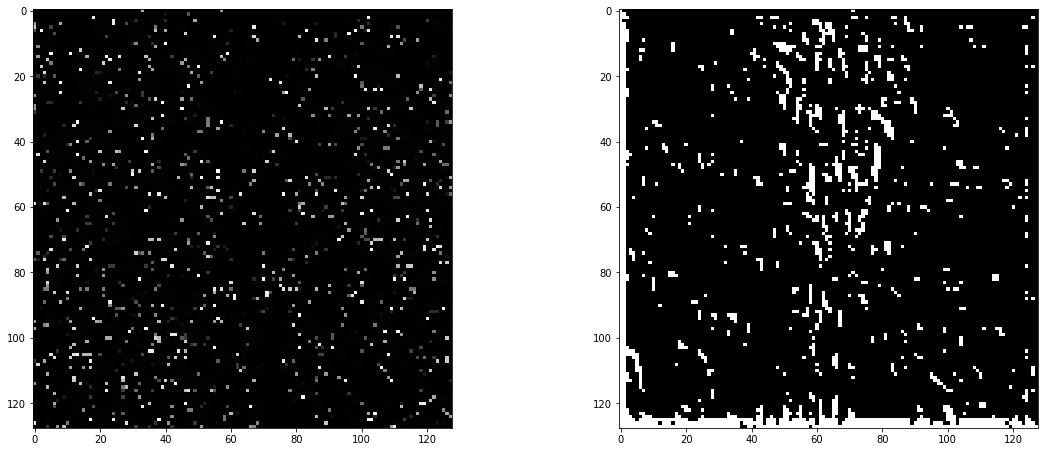

In [126]:
fig = plt.figure()                                                              # block of code for showing the predicted images, it is decent enough sometimes, sometimes not
fig.subplots_adjust(hspace=0.4, wspace=0.4)                                     

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

I commented out one block from the architecture at a time and tried the model, it was giving out bigger blobs of pixels where it shouldn't have. As per class discussions this was because of the model not being able to read and understand complex shape boundaries properly. 
Couldn't try the number of layers properly but from my reading about unet, number of filters per layer would be directly proportional to detail that the model can read from the image.